# 1단계: 환경 설정

In [ ]:
!pip install requests pymongo voyageai dnspython langchain langchain-aws langchain-openai tqdm Pillow

from pymongo import MongoClient

# MongoDB 연결 문자열을 넣습니다.
MONGODB_URI = ""
# Voyage AI API Key를 넣습니다.
VOYAGE_API_KEY = ""

MONGODB_URI = ""
VOYAGE_API_KEY = ""

# 데이터베이스 이름
DB_NAME = "mdb_ai_workshop"

# MongoDB Python 클라이언트를 초기화합니다.
mongodb_client = MongoClient(MONGODB_URI)
# 서버 연결 상태를 확인합니다.
mongodb_client.admin.command("ping")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


{'ok': 1.0,
 '$clusterTime': {'clusterTime': Timestamp(1764204295, 1),
  'signature': {'hash': b'\x1d/y\x9f\x8a\x95.\xf5M\xf2\x04\xc0m9\x8d\xe4y\xc4\xd0E',
   'keyId': 7563040149550923781}},
 'operationTime': Timestamp(1764204295, 1)}

 ## 유틸리티 함수 정의

In [18]:
from pymongo.collection import Collection
from pymongo.errors import OperationFailure
from typing import List, Dict, Optional
from tqdm import tqdm
from typing import Dict
import time

SLEEP_TIMER = 3

def create_index(collection: Collection, index_name: str, model: Dict) -> None:
    try:
        print(f"Creating the {index_name} index")
        collection.create_search_index(model=model)
    except OperationFailure:
        print(f"{index_name} index already exists, recreating...")
        try:
            print(f"Dropping {index_name} index")
            collection.drop_search_index(name=index_name)

            # Poll for index deletion to complete
            while True:
                indexes = list(collection.list_search_indexes())
                index_exists = any(idx.get("name") == index_name for idx in indexes)
                if not index_exists:
                    print(f"{index_name} index deletion complete")
                    break
                print(f"Waiting for {index_name} index deletion to complete...")
                time.sleep(SLEEP_TIMER)

            print(f"Creating new {index_name} index")
            collection.create_search_index(model=model)
            print(f"Successfully recreated the {index_name} index")
        except Exception as e:
            raise Exception(f"Error during index recreation: {str(e)}")


def check_index_ready(collection: Collection, index_name: str) -> None:
    while True:
        indexes = list(collection.list_search_indexes())
        matching_indexes = [idx for idx in indexes if idx.get("name") == index_name]

        if not matching_indexes:
            print(f"{index_name} index not found")
            time.sleep(SLEEP_TIMER)
            continue

        index = matching_indexes[0]
        status = index["status"]
        if status == "READY":
            print(f"{index_name} index status: READY")
            print(f"{index_name} index definition: {index['latestDefinition']}")
            break

        print(f"{index_name} index status: {status}")
        time.sleep(SLEEP_TIMER)

# 2단계: MongoDB로 데이터 가져오기

##### 아래 변수중 **DB_NAME**을 자신의 이메일 앞자리로 변경합니다

In [ ]:
# 컬렉션 이름
COLLECTION_NAME = "books"
# 벡터 검색 인덱스 이름
ATLAS_SEARCH_INDEX_NAME = f"{DB_NAME}_search_index"
VECTOR_SEARCH_INDEX_NAME = f"{DB_NAME}_vector_search_index"
VECTOR_SEARCH_INDEX_NAME_PRE_FILTER = f"{DB_NAME}_vector_search_index_pre_filter"
VECTOR_SEARCH_INDEX_NAME_QUANTIZED = f"{DB_NAME}_vector_search_index_quantized"

collection = mongodb_client[DB_NAME][COLLECTION_NAME]

In [5]:
import json

with open("./assets/datas/books.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"{COLLECTION_NAME} 컬렉션에서 기존 문서를 삭제합니다.")
collection.delete_many({})
collection.insert_many(data)
print(
    f"{collection.count_documents({})}개의 문서가 {COLLECTION_NAME} 컬렉션에 입력되었습니다."
)

books 컬렉션에서 기존 문서를 삭제합니다.
20개의 문서가 books 컬렉션에 입력되었습니다.


# 3단계: Search Index 생성

In [ ]:
search_model = {
    "name": ATLAS_SEARCH_INDEX_NAME,
    "type": "search",
    "definition": {
        "mappings": {"dynamic": False, "fields": {"title": {"type": "string"}}}
    },
}

In [ ]:
# `create_index` 함수를 사용하여 위 정의대로 벡터 검색 인덱스를 생성합니다.
create_index(collection, ATLAS_SEARCH_INDEX_NAME, search_model)

Creating the mongodb_genai_devday_vs_search_index index


In [ ]:
# 진행하기 전에 `check_index_ready` 함수를 사용하여 인덱스가 생성되었고 'READY' 상태인지 확인합니다.
check_index_ready(ATLAS_SEARCH_INDEX_NAME, collection, VECTOR_SEARCH_INDEX_NAME)

mongodb_genai_devday_vs_vector_search_index index status: READY
mongodb_genai_devday_vs_vector_search_index index definition: {'fields': [{'type': 'vector', 'path': 'embedding', 'numDimensions': 1024, 'similarity': 'cosine'}, {'type': 'filter', 'path': 'year'}]}


# 4단계: 검색 쿼리 수행하기

https://www.mongodb.com/docs/atlas/atlas-search/operators-collectors/text/#basic-example 참고

In [12]:
from PIL import Image
import requests

# 검색을 사용하여 사용자 쿼리에 대한 관련 문서를 검색하는 함수를 정의합니다.
def search(
    user_query: str
) -> None:
    pipeline = [
        {
            "$search": {
                "index": ATLAS_SEARCH_INDEX_NAME,
                "text": {"query": user_query, "path": "title"},
            }
        },
        {"$project": {"_id": 0, "title": 1, "cover": 1, "year":1, "pages":1, "score": {"$meta": "vectorSearchScore"}}}
    ] # <CODE_BLOCK>

    # Aggregation `pipeline`을 실행하고 결과를 `results`에 저장합니다.
    results = collection.aggregate(pipeline) # <CODE_BLOCK>

    # 책 제목, 점수, 표지 이미지를 출력합니다.
    for book in results:
        cover = Image.open(requests.get(book.get("cover"), stream=True).raw).resize((100,150))
        print(f"{book.get('title')}({book.get('year')}, {book.get('pages')} pages): {book.get('score')}")
        display(cover)

Ocean Sea(2000, 256 pages): None


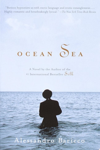

Sea Feather (An Avon Camelot Book)(1999, 74 pages): None


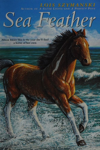

Dragon of the Lost Sea (Dragon Series)(1988, 224 pages): None


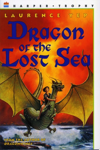

In [ ]:
# 텍스트 쿼리로 검색을 테스트합니다.

search("sea")

# 5단계: 임베딩 생성

In [15]:
import voyageai
from PIL import Image

# Voyage AI 클라이언트를 초기화합니다.
vo = voyageai.Client(api_key=VOYAGE_API_KEY)

/Users/kokyoung.kim/Projects/mongodb-kor-ps-gen-ai-workshop/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 텍스트 임베딩 실습
📚 https://docs.voyageai.com/docs/multimodal-embeddings#python-api (예제 참고)

In [16]:
text = "Puppy Preschool: Raising Your Puppy Right---Right from the Start!"
# 텍스트 데이터를 임베딩하기 위해 `multimodal_embed` 메서드를 사용합니다.
embedding = vo.multimodal_embed(inputs=[[text]], model="voyage-multimodal-3")

embedding.embeddings[0]

[0.0267333984375,
 -0.018798828125,
 -0.03564453125,
 -0.047119140625,
 -0.0186767578125,
 0.0269775390625,
 -0.01318359375,
 0.00592041015625,
 -0.03271484375,
 0.007476806640625,
 -0.0301513671875,
 -0.00604248046875,
 0.02294921875,
 0.007415771484375,
 0.0177001953125,
 -0.01458740234375,
 -0.06005859375,
 0.00112152099609375,
 0.07177734375,
 0.00830078125,
 -0.01708984375,
 -0.000690460205078125,
 -0.0279541015625,
 -0.022216796875,
 0.000965118408203125,
 0.0076904296875,
 -0.03857421875,
 0.01165771484375,
 0.0380859375,
 -0.0213623046875,
 -0.01385498046875,
 -0.033203125,
 0.031494140625,
 -0.01318359375,
 0.058349609375,
 0.020263671875,
 -0.003204345703125,
 0.032958984375,
 -0.0218505859375,
 -0.00787353515625,
 -0.046142578125,
 -0.00122833251953125,
 -0.01104736328125,
 0.02001953125,
 -0.048583984375,
 -0.035888671875,
 -0.040771484375,
 -0.025634765625,
 0.013916015625,
 -0.0159912109375,
 -0.0031585693359375,
 0.028564453125,
 -0.036376953125,
 0.00665283203125,
 -0.0

### 이미지 임베딩 실습

In [17]:
image_url = "https://images.isbndb.com/covers/4318463482198.jpg"
# 위 URL에서 이미지를 불러옵니다.
image = Image.open(requests.get(image_url, stream=True).raw)
# Voyage AI API의 `multimodal_embed` 메서드를 사용하여 이미지를 임베딩합니다:
# inputs: 리스트의 리스트 형태로 이미지를 감싸서 전달
# model: `voyage-multimodal-3` 사용

embedding = vo.multimodal_embed(inputs=[[image]], model="voyage-multimodal-3") #<CODE_BLOCK>

# 객체에서 임베딩 결과(리스트)를 가져옵니다.
embedding.embeddings[0]

[0.0225830078125,
 0.016357421875,
 0.0595703125,
 -0.0081787109375,
 -0.03955078125,
 -0.006927490234375,
 -0.0081787109375,
 0.03076171875,
 0.0101318359375,
 0.031494140625,
 -0.00142669677734375,
 -0.015380859375,
 0.0252685546875,
 0.0311279296875,
 -0.022216796875,
 -0.01275634765625,
 0.04541015625,
 -0.01220703125,
 0.05615234375,
 0.0045166015625,
 0.0274658203125,
 0.007110595703125,
 -0.04052734375,
 -0.002166748046875,
 0.0166015625,
 -0.05908203125,
 -0.0245361328125,
 -0.07470703125,
 0.0142822265625,
 -0.01226806640625,
 0.04150390625,
 -0.010498046875,
 -0.0113525390625,
 0.007415771484375,
 -0.0194091796875,
 -0.0103759765625,
 0.06103515625,
 0.00384521484375,
 0.0179443359375,
 0.0225830078125,
 0.021728515625,
 0.042724609375,
 0.010009765625,
 -0.0546875,
 -0.051025390625,
 0.01300048828125,
 -0.010498046875,
 -0.0264892578125,
 -0.0017547607421875,
 0.0264892578125,
 -0.01544189453125,
 0.0038909912109375,
 -0.05810546875,
 0.038330078125,
 -0.0390625,
 -0.0285644

# 6단계: MongoDB의 기존 데이터에 임베딩 추가하기

In [19]:
# 임베딩할 문서의 필드 (여기서는 책 표지 이미지)
field_to_embed = "cover"
# 문서에 추가될 임베딩 필드의 이름
embedding_field = "embedding"

In [20]:
def get_embeddings(content: str, mode: str, input_type: str) -> List[float]:
    # 입력이 이미지인 경우, 먼저 이미지 콘텐츠를 로드합니다.
    if mode == "image":
        if content.startswith("http"):
            content = Image.open(requests.get(content, stream=True).raw)
        else:
            content = Image.open(content)
    return vo.multimodal_embed(inputs=[[content]], model="voyage-multimodal-3", input_type=input_type).embeddings[0]

📚 https://www.mongodb.com/docs/manual/tutorial/query-documents/#select-all-documents-in-a-collection

In [21]:
# `collection` 컬렉션의 모든 문서를 조회합니다.
results = collection.find({}) # <CODE_BLOCK>

📚 **$set:** https://www.mongodb.com/docs/manual/reference/operator/update/set/#syntax

📚 **update_one():** https://www.mongodb.com/docs/manual/reference/method/db.collection.updateOne/#definition

In [22]:
# 컬렉션 내 각 문서에 임베딩을 추가합니다.
for result in tqdm(results):
    content = result[field_to_embed]
    # 위에서 정의한 `get_embeddings` 함수를 사용하여 `content`를 임베딩합니다.
    # `content`는 책 표지 이미지이므로 `mode`를 그에 맞게 설정하세요.
    # 검색 대상인 "문서"를 임베딩하므로 `input_type`은 "document"로 설정해야 합니다.
    embedding = get_embeddings(content, "image", "document") #<CODE_BLOCK>
    # 현재 문서의 `_id`와 일치하는 문서를 필터링합니다.
    filter = {"_id": result["_id"]}
    # `$set` 연산자를 사용하여 `embedding_field` 필드에 `embedding` 값을 설정합니다.
    update = {"$set": {embedding_field: embedding}} # <CODE_BLOCK>
    # `update_one()` 작업을 사용하여 컬렉션 내 문서를 제자리(inplace) 업데이트합니다.
    # `filter`를 사용하여 올바른 문서 `_id`를 찾고 `update`를 적용하세요.
    collection.update_one(filter, update) # <CODE_BLOCK>

0it [00:00, ?it/s]

20it [00:22,  1.15s/it]


# 7단계: 벡터 검색 인덱스 생성

In [ ]:
# 벡터 인덱스 정의를 생성합니다. 다음 항목들을 지정하세요:
# path: 임베딩 필드의 경로
# numDimensions: 임베딩 차원 수 (사용된 임베딩 모델에 따라 다름)
# similarity: 유사도 측정 방식 (cosine, euclidean, dotProduct 중 하나)
vector_search_model = {
    "name": VECTOR_SEARCH_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1024,
                "similarity": "cosine",
            }
        ]
    },
}

In [ ]:
# `create_index` 함수를 사용하여 위 정의대로 벡터 검색 인덱스를 생성합니다.
create_index(collection, VECTOR_SEARCH_INDEX_NAME, vector_search_model)

Creating the mongodb_genai_devday_vs_vector_search_index index
mongodb_genai_devday_vs_vector_search_index index already exists, recreating...
Dropping mongodb_genai_devday_vs_vector_search_index index
Waiting for mongodb_genai_devday_vs_vector_search_index index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index index deletion to complete...
mongodb_genai_devday_vs_vector_search_index index deletion complete
Creating new mongodb_genai_devday_vs_vecto

In [25]:
# 진행하기 전에 `check_index_ready` 함수를 사용하여 인덱스가 생성되었고 'READY' 상태인지 확인합니다.
check_index_ready(collection, VECTOR_SEARCH_INDEX_NAME)

mongodb_genai_devday_vs_vector_search_index index status: PENDING
mongodb_genai_devday_vs_vector_search_index index status: PENDING
mongodb_genai_devday_vs_vector_search_index index status: PENDING
mongodb_genai_devday_vs_vector_search_index index status: PENDING
mongodb_genai_devday_vs_vector_search_index index status: PENDING
mongodb_genai_devday_vs_vector_search_index index status: PENDING
mongodb_genai_devday_vs_vector_search_index index status: READY
mongodb_genai_devday_vs_vector_search_index index definition: {'fields': [{'type': 'vector', 'path': 'embedding', 'numDimensions': 1024, 'similarity': 'cosine'}]}


# 8단계: 벡터 검색 쿼리 수행하기

https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/#ann-examples ("Filter Example" 참고)

In [ ]:
# 벡터 검색을 사용하여 사용자 쿼리에 대한 관련 문서를 검색하는 함수를 정의합니다.
def vector_search(
    index_name: str, user_query: str, mode: str, filter: Optional[Dict] = {}
) -> None:
    # 4단계에서 정의한 `get_embeddings` 함수를 사용하여 `user_query`에 대한 임베딩을 생성합니다.
    # 쿼리를 임베딩하므로 `input_type`은 "query"로 설정해야 합니다.
    query_embedding = get_embeddings(user_query, mode, "query") #<CODE_BLOCK>

    # $vectorSearch 스테이지와 $project 스테이지로 구성된 Aggregation 파이프라인을 정의합니다.
    # 후보(candidates) 수는 20개로 설정하고, 벡터 검색 결과 상위 5개 문서만 반환합니다.
    # $vectorSearch 스테이지의 `filter` 필드에 함수로 전달된 `filter` 값을 설정합니다.
    # $project 스테이지에서는 `_id` 필드를 제외하고, `title`, `cover`, `year`, `pages`, 그리고 `vectorSearchScore`를 포함합니다.
    # 참고: $vectorSearch 스테이지의 `index`, `queryVector`, `path` 필드에는 이전에 정의한 변수를 사용하세요.
    pipeline = [
        {
            "$vectorSearch": {
                "index": index_name,
                "queryVector": query_embedding,
                "path": "embedding",
                "numCandidates": 20,
                "filter": filter,
                "limit": 5,
            }
        },
        {"$project": {"_id": 0, "title": 1, "cover": 1, "year":1, "pages":1, "score": {"$meta": "vectorSearchScore"}}}
    ] # <CODE_BLOCK>

    # Aggregation `pipeline`을 실행하고 결과를 `results`에 저장합니다.
    results = collection.aggregate(pipeline) # <CODE_BLOCK>

    # 책 제목, 점수, 표지 이미지를 출력합니다.
    for book in results:
        cover = Image.open(requests.get(book.get("cover"), stream=True).raw).resize((100,150))
        print(f"{book.get('title')}({book.get('year')}, {book.get('pages')} pages): {book.get('score')}")
        display(cover)

Sea Feather (An Avon Camelot Book)(1999, 74 pages): 0.629510760307312


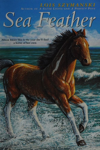

Ocean Sea(2000, 256 pages): 0.6123338937759399


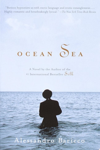

Dragon of the Lost Sea (Dragon Series)(1988, 224 pages): 0.6102570295333862


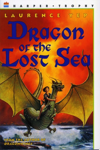

King Lear (Oxford School Shakespeare Series)(2002, 224 pages): 0.5440627336502075


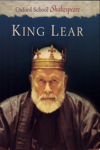

Raising Blaze: A Mother and Son's Long, Strange Journey into Autism(2003, 316 pages): 0.5422289371490479


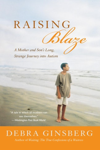

In [ ]:
# 텍스트 쿼리로 벡터 검색을 테스트합니다.
vector_search(VECTOR_SEARCH_INDEX_NAME, "sea", "text")

# 다음 텍스트 쿼리들도 시도해 보세요:
# - A man wearing a golden crown
# - A rainbow of lively colors
# - Creatures wondrous or familiar
# - A boy and the ocean
# - Houses

Ocean Sea(2000, 256 pages): 0.9898547530174255


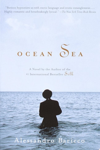

Sea Feather (An Avon Camelot Book)(1999, 74 pages): 0.7575587034225464


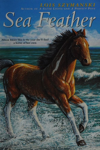

Dragon of the Lost Sea (Dragon Series)(1988, 224 pages): 0.7290562391281128


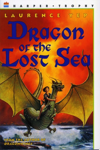

Watership Down(1975, 478 pages): 0.7085471749305725


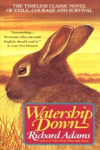

The Water and the Blood: A Novel(2001, 416 pages): 0.6955267190933228


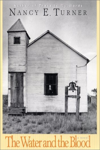

In [28]:
# 이미지 쿼리로 벡터 검색을 테스트합니다.
vector_search(VECTOR_SEARCH_INDEX_NAME, "https://images.isbndb.com/covers/20721003482321.jpg", "image")

# 다음 이미지 쿼리들도 시도해 보세요:
# - ../data/images/salad.jpg
# - ../data/images/kitten.png
# - ../data/images/barn.png

# 9단계: 벡터 검색에 사전 필터(Pre-filters) 추가하기

### `2002`년 이후 출판되었고, 페이지 수가 `250`쪽 이하인 책 필터링하기

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/#about-the-filter-type

In [ ]:
# 5단계의 벡터 검색 인덱스 `model`을 수정하여 `year` 필드를 `filter` 필드로 추가합니다.
vector_search_per_filter_model = {
    "name": VECTOR_SEARCH_INDEX_NAME_PRE_FILTER,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1024,
                "similarity": "cosine",
            },
            {"type": "filter", "path": "year"},
            {"type": "filter", "path": "pages"},
        ]
    }
}

In [ ]:
# `create_index` 함수를 사용하여 수정된 모델로 벡터 검색 인덱스를 재생성합니다.
create_index(collection, vector_search_per_filter_model)

Creating the mongodb_genai_devday_vs_vector_search_index_pre_filter index
mongodb_genai_devday_vs_vector_search_index_pre_filter index already exists, recreating...
Dropping mongodb_genai_devday_vs_vector_search_index_pre_filter index
Waiting for mongodb_genai_devday_vs_vector_search_index_pre_filter index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index_pre_filter index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index_pre_filter index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index_pre_filter index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index_pre_filter index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index_pre_filter index deletion to complete...
Waiting for mongodb_genai_devday_vs_vector_search_index_pre_filter index deletion to complete...
mongodb_genai_devday_vs_vector_search_index_pre_filter index deletion complete
Creatin

In [46]:
# `check_index_ready` 함수를 사용하여 인덱스에 올바른 필터 필드가 적용되었고 'READY' 상태인지 확인합니다.
check_index_ready(collection, VECTOR_SEARCH_INDEX_NAME_PRE_FILTER)

mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: PENDING
mongodb_genai_devday_vs_vector_search_index_pre_filter index status: READY
mongodb_genai_devday_vs_vector_search_index_pre_filter index definition: {'fields': [{'type': 'vector', 'path': 'embedding', 'numDimensions': 1024, 'similarity': 'cosine'}, {'type': 'filter', 'path': 'year'}]}


📚 https://www.mongodb.com/docs/manual/reference/operator/query/gte/#syntax
📚 https://www.mongodb.com/docs/manual/reference/operator/query/lte/#mongodb-query-op.-lte

In [ ]:
# `year` 필드가 `2002` 이상이고(`$gte`), `pages` 필드가 `250` 이하인(`$lte`) 책을 필터링하는 정의를 생성합니다.
filter = {"$and": [{"year": {"$gte": 2002}}, {"pages": {"$lte": 250}}]} # <CODE_BLOCK>
# `filter`를 `vector_search` 함수의 인자로 전달합니다.
# 이 필터가 `vector_search` 함수 내의 `pipeline`에 어떻게 통합되는지 확인해 보세요.
vector_search(VECTOR_SEARCH_INDEX_NAME_PRE_FILTER, "A boy and the ocean", "text", filter)

# 10단계: 벡터 양자화(Vector Quantization) 활성화 (skip)

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/#syntax

In [ ]:
# 5단계의 벡터 검색 인덱스 `model`을 수정하여 `scalar` 양자화를 사용하도록 설정합니다.
vector_search_quantized_model = {
    "name": VECTOR_SEARCH_INDEX_NAME_QUANTIZED,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1024,
                "similarity": "cosine",
                "quantization": "scalar",
            },
        ]
    },
}

In [ ]:
# `utils` 모듈의 `create_index` 함수를 사용하여 수정된 모델로 벡터 검색 인덱스를 재생성합니다.
create_index(collection, VECTOR_SEARCH_INDEX_NAME_QUANTIZED, vector_search_quantized_model)

In [ ]:
# `check_index_ready` 함수를 사용하여 양자화가 활성화된 상태로 인덱스가 생성되었는지 확인합니다.
check_index_ready(collection, VECTOR_SEARCH_INDEX_NAME_QUANTIZED)

# 11단계: Hybrid 검색 수행

**참고:** 아래 하이브리드 검색 쿼리는 검색과 벡터 검색을 수동으로 조합하는 방식입니다.

$rankFusion 이라는 새로운 Aggreation Stage가 Preview로 제공되고있습니다

https://www.mongodb.com/docs/atlas/atlas-vector-search/hybrid-search/vector-search-with-full-text-search/#run-a-combined-semantic-search-and-full-text-search-query-using--rankfusion

In [33]:
def hybrid_search(
    user_query: str, vector_weight: float, full_text_weight: float
) -> None:
    """
    하이브리드 검색을 사용하여 사용자 쿼리에 대한 관련 문서를 검색합니다.

    Args:
        user_query (str): 사용자 쿼리 문자열
        vector_weight (float): 최종 검색 결과에서 벡터 검색이 차지하는 가중치
        full_text_weight (float): 최종 검색 결과에서 전문 검색이 차지하는 가중치
    """
    pipeline = [
        # 벡터 검색(Vector search) 스테이지
        {
            "$vectorSearch": {
                "index": VECTOR_SEARCH_INDEX_NAME,
                "path": "embedding",
                "queryVector": get_embeddings(user_query, "text", "query"),
                "numCandidates": 20,
                "limit": 10,
            }
        },
        # 벡터 검색으로 반환된 모든 문서를 'docs'라는 하나의 배열로 그룹화합니다.
        {"$group": {"_id": None, "docs": {"$push": "$$ROOT"}}},
        # 'docs' 필드의 문서 배열을 풀고(unwind), 배열 내 문서의 위치(인덱스)를 'rank'라는 필드에 저장합니다.
        {"$unwind": {"path": "$docs", "includeArrayIndex": "rank"}},
        # 'docs' 배열의 각 문서에 대해 Reciprocal Rank(상호 순위) 점수를 계산하여 'vs_score' 필드에 추가합니다.
        {
            "$addFields": {
                "vs_score": {
                    "$multiply": [
                        vector_weight,
                        {"$divide": [1.0, {"$add": ["$rank", 60]}]},
                    ]
                }
            }
        },
        # 결과에 'vs_score', '_id', 'title', 'cover' 필드만 포함합니다.
        {
            "$project": {
                "vs_score": 1,
                "_id": "$docs._id",
                "title": "$docs.title",
                "cover": "$docs.cover",
            }
        },
        # 전문 검색(Full-text search) 스테이지와 결합(Union)합니다.
        {
            "$unionWith": {
                "coll": COLLECTION_NAME,
                "pipeline": [
                    # 전문 검색(Full-text search)
                    {
                        "$search": {
                            "index": ATLAS_SEARCH_INDEX_NAME,
                            "text": {"query": user_query, "path": "title"},
                        }
                    },
                    # 전문 검색 결과를 10개로 제한합니다.
                    {"$limit": 10},
                    # 전문 검색으로 반환된 모든 문서를 'docs'라는 하나의 배열로 그룹화합니다.
                    {"$group": {"_id": None, "docs": {"$push": "$$ROOT"}}},
                    # 'docs' 필드의 문서 배열을 풀고(unwind), 배열 내 문서의 위치(인덱스)를 'rank' 필드에 저장합니다.
                    {"$unwind": {"path": "$docs", "includeArrayIndex": "rank"}},
                    # 'docs' 배열의 각 문서에 대해 Reciprocal Rank(상호 순위) 점수를 계산하여 'fts_score' 필드에 추가합니다.
                    {
                        "$addFields": {
                            "fts_score": {
                                "$multiply": [
                                    full_text_weight,
                                    {"$divide": [1.0, {"$add": ["$rank", 60]}]},
                                ]
                            }
                        }
                    },
                    # 결과에 'fts_score', '_id', 'title', 'cover' 필드만 포함합니다.
                    {
                        "$project": {
                            "fts_score": 1,
                            "_id": "$docs._id",
                            "title": "$docs.title",
                            "cover": "$docs.cover",
                        }
                    },
                ],
            }
        },
        # 다음 스테이지들은 벡터 검색과 전문 검색 결과를 하나의 순위 목록으로 결합합니다.
        # 결과를 `title`, `vs_score`, `fts_score` 기준으로 그룹화합니다.
        {
            "$group": {
                "_id": "$_id",
                "title": {"$first": "$title"},
                "vs_score": {"$max": "$vs_score"},
                "fts_score": {"$max": "$fts_score"},
                "cover": {"$first": "$cover"},
            }
        },
        # 결과에 `_id`, `title`, `cover`, `vs_score`, `fts_score` 필드만 포함합니다.
        {
            "$project": {
                "_id": 1,
                "title": 1,
                "vs_score": {"$ifNull": ["$vs_score", 0]},
                "fts_score": {"$ifNull": ["$fts_score", 0]},
                "cover": 1,
            }
        },
        # `vs_score`와 `fts_score`의 합계를 포함하는 `score` 필드를 추가합니다.
        {
            "$project": {
                "score": {"$add": ["$fts_score", "$vs_score"]},
                "_id": 1,
                "title": 1,
                "vs_score": 1,
                "fts_score": 1,
                "cover": 1,
            }
        },
        # `score`를 기준으로 내림차순 정렬합니다.
        {"$sort": {"score": -1}},
        # 결과를 상위 5개로 제한합니다.
        {"$limit": 5},
    ]

    results = collection.aggregate(pipeline)

    # Print book title, scores, and cover image
    for book in results:
        cover = Image.open(requests.get(book["cover"], stream=True).raw).resize(
            (100, 150)
        )
        print(
            f"{book.get('title')}, VS Score: {book.get('vs_score')}, FTS Score: {book.get('fts_score')}"
        )
        display(cover)

Prodigal Summer, VS Score: 0.13333333333333333, FTS Score: 0.03278688524590164


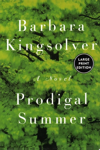

My Favorite Summer 1956, VS Score: 0.13114754098360656, FTS Score: 0.03333333333333333


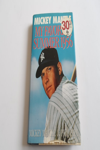

Raising Blaze: A Mother and Son's Long, Strange Journey into Autism, VS Score: 0.12903225806451613, FTS Score: 0


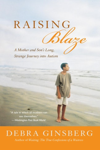

Exiting Nirvana: A Daughter's Life with Autism, VS Score: 0.12698412698412698, FTS Score: 0


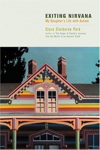

Fresh Ways with Salads:  As Side Dishes or Main Courses (Sunset), VS Score: 0.125, FTS Score: 0


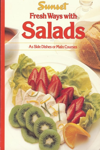

In [36]:
# 하이브리드 검색을 테스트합니다. (벡터 검색 가중치 1.0, 전문 검색 가중치 0.0)
hybrid_search(
    user_query="My Favorite Summer",
    vector_weight=8.0,
    full_text_weight=2.0,
)

My Favorite Summer 1956, VS Score: 0.004918032786885246, FTS Score: 0.011666666666666665


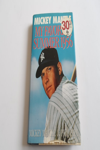

Prodigal Summer, VS Score: 0.005, FTS Score: 0.011475409836065573


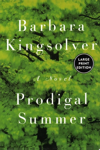

Raising Blaze: A Mother and Son's Long, Strange Journey into Autism, VS Score: 0.004838709677419354, FTS Score: 0


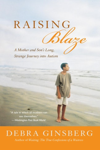

Exiting Nirvana: A Daughter's Life with Autism, VS Score: 0.0047619047619047615, FTS Score: 0


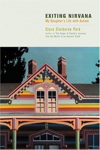

Fresh Ways with Salads:  As Side Dishes or Main Courses (Sunset), VS Score: 0.0046875, FTS Score: 0


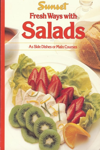

In [35]:
# 하이브리드 검색을 테스트합니다. (벡터 검색 가중치 0.3, 전문 검색 가중치 0.7)
hybrid_search(
    user_query="My Favorite Summer",
    vector_weight=0.3,
    full_text_weight=0.7,
)